# Parametric uncertainty and sensitivity analysis

# ALIGNED project: OTA tutorial

**Aligning Life Cycle Assessment methods and bio-based sectors for improved environmental performance**

[http://www.alignedproject.eu/](http://www.alignedproject.eu/)

_Horizon Europe grant agreement N° 101059430. Views and opinions expressed are however those of the author(s) only and do not necessarily reflect those of the European Union or the European Research Executive Agency._ 

## WP1 Shared modelling framework and learnings
### Task 1.4 Framework for interpreting uncertainty
#### Deliverable 1.2 Description of scientific methods
#### Tutorial for performing parametrized sensitivity and uncertainty analyses
Rebecca Belfiore, Institut National des Sciences Appliquées Toulouse (INSAT), 2025

This notebook show how to perform a simple uncertainty and sensitivity analyses (OAT, GSA, and MC) for parametrized inventories.

In [9]:
# Import brightway2.5 packages
import bw2calc as bc
import bw2data as bd
import bw2io as bi
import bw_processing as bwp
from bw2data.parameters import *
from bw2data.backends.schema import ExchangeDataset

# Import other relevant packages
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

# Import specific functions to import LCI
from lci_to_bw2 import *
from Importer_parameters import * # this is to import parameters

## Import Data

In [10]:
# Select a project that contains the right versions of ecoinvent and biosphere
bd.projects.set_current('advlca25')
bd.databases

Databases dictionary with 5 object(s):
	ALIGNED-biob-prod-dummy
	ALIGNED-biob-prod-dummy-alt
	cmc
	ecoinvent-3.11-biosphere
	ecoinvent-3.11-consequential

In [11]:
# Import the dummy product system with the added columns 'formula' and 'group'
# import data from csv
import os
mydata = pd.read_csv(os.path.join(os.getcwd(), 'ALIGNED-LCI-biobased-product-dummy-with-parameters.csv'), header = 0, sep = ",") # using csv file avoids encoding problem

bw2_db = lci_to_bw2(mydata) # a function from the lci_to_bw2 module

# write database
bd.Database('ALIGNED-biob-prod-dummy').write(bw2_db)

13:13:35+0200 [warning  ] Not able to determine geocollections for all datasets. This database is not ready for regionalization.


100%|██████████| 5/5 [00:00<00:00, 7648.26it/s]

13:13:35+0200 [info     ] Vacuuming database            


Take a look at the activities imported and the relative flows as well as the formulas of the parametrized flows

In [12]:
for a in bd.Database('ALIGNED-biob-prod-dummy'):
    print(a)
    for e in a.exchanges():
        print(e)
        e_dic = dict(e)
        if e_dic.get('formula') is not None:
            print(e_dic['formula'],e_dic['group'])

'Biomass-processing' (kilogram, None, None)
Exchange: 1.0 kilogram 'Biomass-processing' (kilogram, None, None) to 'Biomass-processing' (kilogram, None, None)>
Exchange: 0.5 kilowatt hour 'market for electricity, medium voltage' (kilowatt hour, DK, None) to 'Biomass-processing' (kilogram, None, None)>
Exchange: 0.5 kilogram 'market for chemical, organic' (kilogram, GLO, None) to 'Biomass-processing' (kilogram, None, None)>
(chemical_constant*(1-water_content))/reactor_efficiency activity_group
'Biobased-product-eol' (kilogram, None, None)
Exchange: 1.0 kilogram 'Biobased-product-eol' (kilogram, None, None) to 'Biobased-product-eol' (kilogram, None, None)>
Exchange: 0.5 kilowatt hour 'market for electricity, medium voltage' (kilowatt hour, DK, None) to 'Biobased-product-eol' (kilogram, None, None)>
Exchange: 1.0 kilogram 'Carbon dioxide, fossil' (kilogram, None, ('air',)) to 'Biobased-product-eol' (kilogram, None, None)>
'Biobased-product-manufacturing' (kilogram, None, None)
Exchange: 1

### Import parameters

Parameters are imported seperatly from a separate csv

In [13]:
myparameters = pd.read_csv(os.path.join(os.getcwd(), 'ALIGNED-LCI-biobased-product-parameters-dummy.csv'), header = 0, sep = ",") # path to the csv file containing the parameters

parameters_to_bw(myparameters) # a custom function to import parameters

In [14]:
# print out the parameters you imported
for a in ActivityParameter:
    print(a, a.amount)
    a.recalculate_exchanges(a.group) # to recalculate exchanges according to parameter values

Activity parameter: activity_group:water_content 0.4
Activity parameter: activity_group:dry_mass_for_manufacturing 0.3
Activity parameter: activity_group:manufacturing_efficiency 0.9
Activity parameter: activity_group:running_electricity 0.1
Activity parameter: activity_group:chemical_constant 0.5
Activity parameter: activity_group:reactor_efficiency 0.6


## Static LCA 

In [15]:
# calculation of static LCA score
mymethod = ('ecoinvent-3.11', 'IPCC 2021', 'climate change: fossil', 'global warming potential (GWP100)')
myact = bd.Database('ALIGNED-biob-prod-dummy').get('f9eabf64-b899-40c0-9f9f-2009dbb0a0b2') # Biobased-product-use
functional_unit = {myact: 1}
LCA = bc.LCA(functional_unit, mymethod)
LCA.lci()
LCA.lcia()
print("The static Global Warming impact score is", LCA.score, bd.methods[mymethod]['unit'])

The static Global Warming impact score is 180.28497364203196 kg CO2-Eq


We can now perform OAT, GSA, and MC on parametric inventories

## OAT analysis

In [16]:
# run this cell to import the fucntion that will allow to update parameter values
def update_parameter(parameter, amount):
    ''' 
    This function allows to update parameter values to a specific amount

    Inputs:
    - parameter: the Activity parameter object to update
    - amount: the amount to which to set the parameter
    '''
    
    parameter.amount = amount
    parameter.save()

    parameter.recalculate_exchanges(parameter.group)

The next cell will perform the OAT analysis perturbating a parameter at a time and calculating LCA results.

In [17]:
# Iterate through all parameters and change the value up by 10%
par_name = []
par_values = []
par_upper_values = []
score_values = []
OAT_values  = []

mymethod = ('ecoinvent-3.11', 'IPCC 2021', 'climate change: fossil', 'global warming potential (GWP100)')
myact = bd.Database('ALIGNED-biob-prod-dummy').get('f9eabf64-b899-40c0-9f9f-2009dbb0a0b2') # Biobased-product-use
functional_unit = {myact: 1}
LCA = bc.LCA(functional_unit, mymethod)



for p in ActivityParameter: # for all parameters
    par_name.append(p.name)
    start_value = p.amount
    par_values.append(start_value)
    par_upper_values.append(p.amount * 1.1)

    LCA = bc.LCA(demand=functional_unit, method = mymethod)
    LCA.lci()
    LCA.lcia()
    print("initial value", LCA.score)
    
    score_values.append(LCA.score)

    # change the parameter value
    update_parameter(p, start_value * 1.1)

    # recalculate the LCA score
    LCA = bc.LCA(demand=functional_unit, method = mymethod)
    LCA.lci()
    LCA.lcia()
    new_score = LCA.score

    OAT_values.append(LCA.score)

    print(p.name)
    print('end value', LCA.score)
    print("---")
        
    # Restore parameters to their original values...
    update_parameter(p, start_value)

initial value 180.28497364203196
water_content
end value 184.60376194042715
---
initial value 180.28497364203196
dry_mass_for_manufacturing
end value 189.5869665742057
---
initial value 180.28497364203196
manufacturing_efficiency
end value 180.21596042559023
---
initial value 180.28497364203196
running_electricity
end value 180.3039522673404
---
initial value 180.28497364203196
chemical_constant
end value 183.77320604903537
---
initial value 180.28497364203196
reactor_efficiency
end value 177.11385491060764
---


Treat data results to calculate sensitvity ratios

In [18]:
sr = pd.DataFrame([par_name, par_values, par_upper_values, score_values, OAT_values], 
                  index = ['par_name','par_initial', 'par_upper', 'GWI_initial', 'GWI_end']).T
sr.head()

,par_name,par_initial,par_upper,GWI_initial,GWI_end
0,water_content,0.4,0.44,180.284974,184.603762
1,dry_mass_for_manufacturing,0.3,0.33,180.284974,189.586967
2,manufacturing_efficiency,0.9,0.99,180.284974,180.21596
3,running_electricity,0.1,0.11,180.284974,180.303952
4,chemical_constant,0.5,0.55,180.284974,183.773206


In [19]:
# calcualte sensitivity ratios
sr['SR'] = ((sr['GWI_end']-sr['GWI_initial'])/sr['GWI_initial']) / ((sr['par_upper']-sr['par_initial'])/sr['par_initial']) 

sr['SR_abs'] = abs(sr['SR'])

In [20]:
sr_sorted = sr.sort_values('SR_abs', ascending = False, ignore_index = True).copy() # important to re-index...
sr_sorted

,par_name,par_initial,par_upper,GWI_initial,GWI_end,SR,SR_abs
0,dry_mass_for_manufacturing,0.3,0.33,180.284974,189.586967,0.515961,0.515961
1,water_content,0.4,0.44,180.284974,184.603762,0.239553,0.239553
2,chemical_constant,0.5,0.55,180.284974,183.773206,0.193484,0.193484
3,reactor_efficiency,0.6,0.66,180.284974,177.113855,-0.175895,0.175895
4,manufacturing_efficiency,0.9,0.99,180.284974,180.21596,-0.003828,0.003828
5,running_electricity,0.1,0.11,180.284974,180.303952,0.001053,0.001053


The most sensitive parameter is the dry_mass_for_manufacturing, this represents the kg of drymass that must come from growth activity in order to obtain 1kg of product from the manufacturing activity. Since this is the most sensitive parameter we know that by correctly measuring this ratio (dry mass in : product out) will reduce uncertainty the most.

## GSA Analysis

To perform Global Sensitivity Analysis we first select parameters and a series of values to test for each. 

In [21]:
# save all parameters in a list
parameter_list = []
for i, a in enumerate(ActivityParameter):
    print(f'parameter {i+1}:', a.name, a.amount)
    parameter_list.append(a)

parameter 1: water_content 0.4
parameter 2: dry_mass_for_manufacturing 0.3
parameter 3: manufacturing_efficiency 0.9
parameter 4: running_electricity 0.1
parameter 5: chemical_constant 0.5
parameter 6: reactor_efficiency 0.6


In [22]:
# Can be done in many ways, here very basic using lists.
par1_values = [0.36, 0.38, 0.4, 0.42, 0.44] # water_content
par2_values = [0.27, 0.28, 0.3, 0.32, 0.33] # dry_mass_for_manufacturing
par3_values = [0.81, 0.85, 0.9, 0.95, 0.99]  # manufacturing_efficiency
par4_values = [0.09, 0.095, 0.1, 0.11, 0.115] # running_electricity
par5_values = [0.45, 0.47, 0.5, 0.53, 0.55]  # chemical_constant
par6_values = [0.54, 0.57, 0.6, 0.63, 0.66] # reactor_efficiency

In [23]:
n_iter = 5
param_samples = [[parameter_list[0], par1_values],
                 [parameter_list[1], par2_values],
                 [parameter_list[2], par3_values],
                 [parameter_list[3], par4_values],
                 [parameter_list[4], par5_values],
                 [parameter_list[5], par6_values]]

We can now iterate through and change parameter values, recalculate LCA results and calculate correlation between model input values and output values.

In [24]:
mymethod = ('ecoinvent-3.11', 'IPCC 2021', 'climate change: fossil', 'global warming potential (GWP100)')
myact = bd.Database('ALIGNED-biob-prod-dummy').get('f9eabf64-b899-40c0-9f9f-2009dbb0a0b2') # Biobased-product-use
functional_unit = {myact: 1}
LCA = bc.LCA(functional_unit, mymethod)

GSA_value_results = [] # to store output values

for i in range(0,n_iter): 
    
    # calculate inital LCA value
    LCA = bc.LCA(functional_unit, mymethod)
    LCA.lci()
    LCA.lcia()
    print("initial value", LCA.score) 
    
    original = [] # to store the original parameter values

    # change parameter values
    for s in param_samples:
        p = s[0]
        o = p.amount
        original.append(p.amount)
        p.amount = s[1][i]
        p.save()
    
    p.recalculate_exchanges(p.group) # to recalculate flow amounts based on new parameter values

    # recalculate LCA output
    LCA = bc.LCA(functional_unit, mymethod)
    LCA.lci()
    LCA.lcia()
    GSA_value_results.append(LCA.score)
    print('end value', LCA.score)
    print("---")
    

    # reset parameter values to original amounts
    for i, s in enumerate(param_samples):
        update_parameter(s[0], original[i])

initial value 180.28497364203196
end value 168.1414736176963
---
initial value 180.28497364203196
end value 172.10153405840256
---
initial value 180.28497364203196
end value 180.28497364203196
---
initial value 180.28497364203196
end value 189.0451399985393
---
initial value 180.28497364203196
end value 194.52964170579463
---


In [25]:
# calcualte correlation
corr_data = pd.DataFrame([i[1] for i in param_samples], index = [p.name for p in parameter_list]).T
corr_data['GWI'] = GSA_value_results
corr_data.corr()

,water_content,dry_mass_for_manufacturing,manufacturing_efficiency,running_electricity,chemical_constant,reactor_efficiency,GWI
water_content,1.000000,0.992278,0.999056,0.991241,0.997054,1.000000,0.993317
dry_mass_for_manufacturing,0.992278,1.000000,0.996729,0.993044,0.998868,0.992278,0.998898
manufacturing_efficiency,0.999056,0.996729,1.000000,0.993617,0.999445,0.999056,0.997020
running_electricity,0.991241,0.993044,0.993617,1.000000,0.994169,0.991241,0.995672
chemical_constant,0.997054,0.998868,0.999445,0.994169,1.000000,0.997054,0.998585
reactor_efficiency,1.000000,0.992278,0.999056,0.991241,0.997054,1.000000,0.993317
GWI,0.993317,0.998898,0.997020,0.995672,0.998585,0.993317,1.000000


## Monte Carlo

This Monte Carlo simulation will sample both the uncertainty of the parameters, to recalculate exchange values as well as background uncertainties and uncertainties of other foreground non-parametrized flows.

In [26]:
# specific packages for MC
from stats_arrays import MCRandomNumberGenerator, UncertaintyBase

In [27]:
# function to sample parameters
def sample_uncertainty(parameter):
    ''' 
    This function allows to generate a random value based on the uncertainty of the parameter

    Inputs:
    - parameter: the Activity parameter object to update
    
    Returns:
    - a random sample from the uncertainty distribution
    '''

    param = parameter.data

    loc = param.get("loc", np.NaN)
    scale = param.get("scale", np.NaN)
    shape = param.get("shape", np.NaN)
    minimum = param.get("minimum", np.NaN)
    maximum = param.get("maximum", np.NaN)
    uncertainty_type = param.get("uncertainty type", np.NaN)

    params = UncertaintyBase.from_dicts(
    {'loc':loc, 'scale':scale, 'shape':shape, 'minimum':minimum,
      'maximum':maximum, 'uncertainty_type': uncertainty_type},
    )
    mcrng = MCRandomNumberGenerator(params)
    simulations = zip(range(1), mcrng)
    for i in simulations:
        sample = (i[1])[0]

    return sample

In [28]:
mymethod = ('ecoinvent-3.11', 'IPCC 2021', 'climate change: fossil', 'global warming potential (GWP100)')
myact = bd.Database('ALIGNED-biob-prod-dummy').get('f9eabf64-b899-40c0-9f9f-2009dbb0a0b2') # Biobased-product-use
functional_unit = {myact: 1}

mc_results = [] # to store results of each iteration

iterations = 100 # number of iterations

for j in range(iterations):
    
    original = [] # to store all the original values of parameters

    # change all parameters by sampling their uncertainty 
    for p in ActivityParameter:
        original.append(p.amount)
        random_value = sample_uncertainty(p)
        update_parameter(p, random_value) 

    # at this point all the exchanges have been changed 

    # now because parametrized exchanges do not have uncertainties, this line will only sample the distribution of the background and unparametrized foreground flows
    mc = bc.LCA(demand=functional_unit, method=mymethod, use_distributions=True) 
    ## NOTE: use distributions does not consider parameters which is why it is necessary to perform the previous loop
    mc.lci()
    mc.lcia()

    mc_results.append(mc.score)

    # reset parameters to original values
    for i, p in enumerate(ActivityParameter):
        update_parameter(p, original[i])

Some simple plotting to observe results

,0
count,100.000000
mean,233.088443
std,89.727749
min,113.547768
25%,173.758545
50%,213.530639
75%,271.283340
max,658.157744


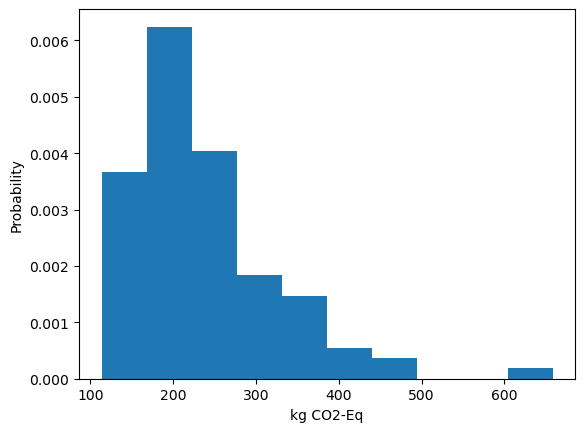

In [29]:
# plot MC results
plt.hist(mc_results, density=True)
plt.ylabel("Probability")
plt.xlabel(bd.methods[mymethod]["unit"])
pd.DataFrame(mc_results).describe() 